In [22]:
import sys
import numpy as np
import os
from os.path import abspath

import matplotlib.pyplot as plt
import sigpy.plot as pl
%matplotlib notebook

import subtle.subtle_preprocess as supre
import subtle.utils.io as utils_io
from deepbrain import Extractor as BrainExtractor

import SimpleITK as sitk

In [8]:
dicom_dir = '/home/subtle/Data/Stanford/lowcon/Patient_0115/'

In [11]:
path_zero, path_low, path_full = utils_io.get_dicom_dirs(dicom_dir)
print(dicom_dirs)
ims_zero, hdr_zero = utils_io.dicom_files(path_zero, normalize=False)
ims_low, hdr_low = utils_io.dicom_files(path_low, normalize=False)
ims_full, hdr_full = utils_io.dicom_files(path_full, normalize=False)

pixel_spacing_zero = utils_io.get_pixel_spacing(hdr_zero)
pixel_spacing_low = utils_io.get_pixel_spacing(hdr_low)
pixel_spacing_full = utils_io.get_pixel_spacing(hdr_full)

ims = np.stack((ims_zero, ims_low, ims_full), axis=1)
print(ims.shape)

['/home/subtle/Data/Stanford/lowcon/Patient_0115/7_AX_BRAVO_PRE', '/home/subtle/Data/Stanford/lowcon/Patient_0115/10_AX_BRAVO_+C', '/home/subtle/Data/Stanford/lowcon/Patient_0115/13_AX_BRAVO+C']
(328, 3, 512, 512)


In [12]:
mask = supre.mask_im(ims)
print(mask.shape)
ims *= mask

(328, 3, 512, 512)


In [16]:
def _mask_npy(img_npy):
    ext = BrainExtractor()

    img_scale = np.interp(img_npy, (img_npy.min(), img_npy.max()), (0, 1))
    segment_probs = ext.run(img_scale)

    mask = supre.get_largest_connected_component(segment_probs > 0.5)
    return mask

In [17]:
bet_zero = _mask_npy(ims[:,0,...])
bet_low = _mask_npy(ims[:,1,...])
bet_full = _mask_npy(ims[:,2,...])


(328, 512, 512)


<IPython.core.display.Javascript object>


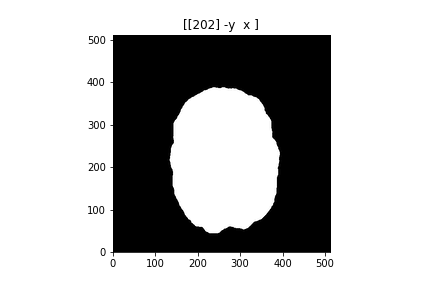

In [20]:
bet = ((bet_zero > 0) | (bet_low > 0) | (bet_full > 0))
print(bet.shape)
pl.ImagePlot(bet)

<IPython.core.display.Javascript object>


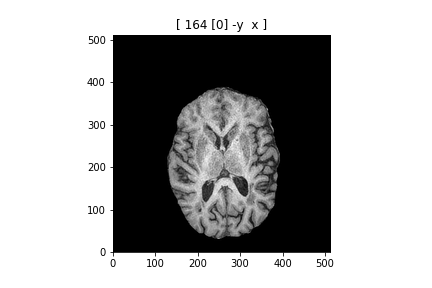

In [32]:
ims_bet = np.zeros(ims.shape)
for ii in range(ims.shape[1]):
    ims_bet[:,ii,...] = bet * ims[:,ii,...]
pl.ImagePlot(ims_bet)

In [28]:
spars = sitk.GetDefaultParameterMap('rigid', 2)
im_bet_low_reg, spars_low = supre.register_im(ims_bet[:,0,...], ims_bet[:,1,...], param_map=spars, verbose=False,
                               im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_low)
im_bet_full_reg, spars_full = supre.register_im(ims_bet[:,0,...], ims_bet[:,2,...], param_map=spars, verbose=False,
                               im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_full)

<IPython.core.display.Javascript object>


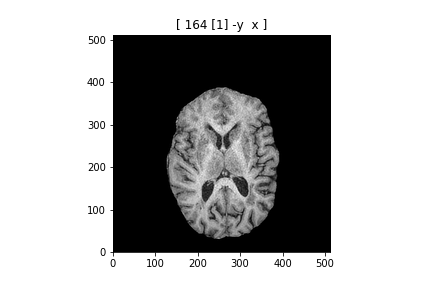

In [31]:
ims_bet_reg = np.stack((ims_bet[:,0,...], im_bet_low_reg, im_bet_full_reg), axis=1)
pl.ImagePlot(ims_bet_reg)

<IPython.core.display.Javascript object>


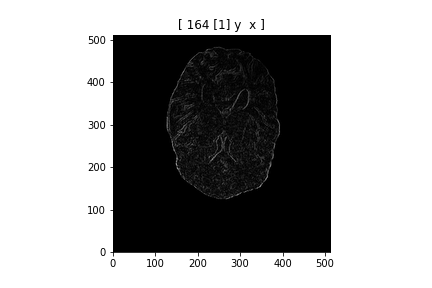

In [33]:
pl.ImagePlot(ims_bet - ims_bet_reg)

In [34]:
spars = sitk.GetDefaultParameterMap('rigid', 2)
im_bet_zero_reg2, spars_low = supre.register_im(ims_bet[:,1,...], ims_bet[:,0,...], param_map=spars, verbose=False,
                               im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_low)
im_bet_full_reg2, spars_full = supre.register_im(ims_bet[:,1,...], ims_bet[:,2,...], param_map=spars, verbose=False,
                               im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_full)

<IPython.core.display.Javascript object>


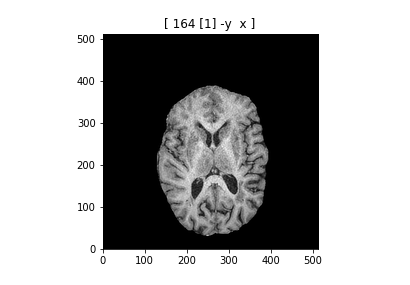

In [35]:
ims_bet_reg2 = np.stack((im_bet_zero_reg2, ims_bet[:,1,...], im_bet_full_reg2), axis=1)
pl.ImagePlot(ims_bet_reg2)

In [37]:
spars = sitk.GetDefaultParameterMap('rigid', 2)
bet_low2, spars_low = supre.register_im(bet_zero.astype(np.float32), bet_low.astype(np.float32), param_map=spars, verbose=False,
                               im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_low)
bet_full2, spars_full = supre.register_im(bet_zero.astype(np.float32), bet_full.astype(np.float32), param_map=spars, verbose=False,
                               im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_full)

<IPython.core.display.Javascript object>


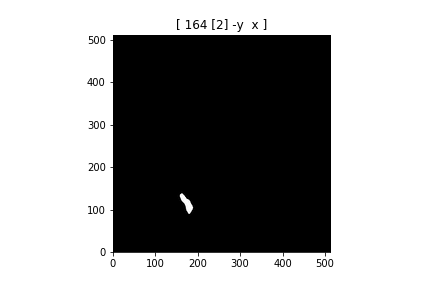

In [40]:
bet_reg2 = np.stack((bet_zero, bet_low, bet_full), axis=1)
pl.ImagePlot(bet_reg2)

<IPython.core.display.Javascript object>


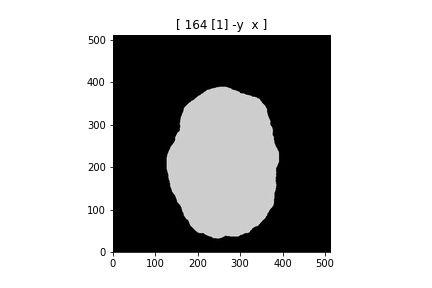

In [39]:
bet_reg2 = np.stack((bet_zero, bet_low2, bet_full2), axis=1)
pl.ImagePlot(bet_reg2)

In [41]:
spars = sitk.GetDefaultParameterMap('rigid', 2)
im_low_reg, spars_low = supre.register_im(ims[:,0,...], ims[:,1,...], param_map=spars, verbose=False,
                               im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_low)
im_full_reg, spars_full = supre.register_im(ims[:,0,...], ims[:,2,...], param_map=spars, verbose=False,
                               im_fixed_spacing=pixel_spacing_zero, im_moving_spacing=pixel_spacing_full)

<IPython.core.display.Javascript object>


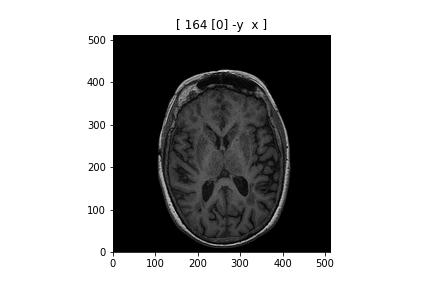

In [43]:
im_reg = np.stack((ims[:,0,...], im_low_reg, im_full_reg), axis=1)
pl.ImagePlot(im_reg)